In [5]:
# %matplotlib widget
# import numpy as np
# import json, glob, copy
# import os, math
# import pandas as pd
# from matplotlib import pyplot as plt
# from scipy.optimize import curve_fit
# from IPython.display import clear_output, display
# from datetime import datetime

%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, time, glob, pickle
from matplotlib import pyplot as plt

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

## choose run number

In [33]:
pgroup='p21621'
runnumber = 103
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
#jsonfile = glob.glob('/sf/alvra/data/{}/work/example_data/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]

titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0103


'/sf/alvra/data/p21621/raw/run0103-t0_stretch_FS_JetYAG/meta/scan.json'

In [34]:
TT = TT_PSEN126

quantile_band = 0.5

channel_delay_motor = channel_delay_topas

Timezero_mm = 190.045820 ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)
reducedir='../Claudio/Reduced_YAG_TT/'
saveflag = True

########################################
#YAG_scan_one_TT(json_file, TT, channel_delay_motor, timezero_mm, quantile, target, calibration, filterTime=2000, filterAmp=0):
#YAG_scan_one_TT_bs(json_file, TT, channel_delay_motor, timezero_mm, quantile, filterTime=2000, filterAmp=0):
########################################
flag = True

try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:
    Timezero_mm = Timezero_mm

from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
    
Delay_rbk, Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
YAG_scan_one_TT_bs(scan, TT, channel_delay_motor, Timezero_mm, quantile_band)

if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_run_array_YAG_TT(reducedir, run_name, Delay_rbk, Delay_fs, Delays_corr,
                   Pump_probe, Pump_probe_scan)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

    #Delays_corr -= Delay_fs

#pp_uncorrected = Pump_probe[:,0]
#err_pp_low = Pump_probe[:,1]
#err_pp_high = Pump_probe[:,2]

Processing: run0103-t0_stretch_FS_JetYAG
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                  251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                247 / 251 -> 2% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET            251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET            251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 247 / 251 -> 2

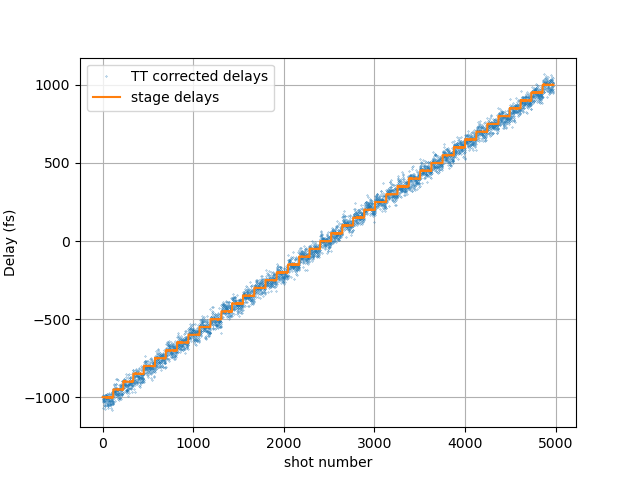

In [35]:
plt.figure()
plt.plot(Delays_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delay_fs, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

## Re-bin the data with chosen binsize

In [36]:
binsize = 20 # in fs

min_delay = -1000
max_delay = 1000

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic=np.nanmean, bins=binList)

(4978,) (4978,)


## Choose fit function

In [37]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit

In [38]:
index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
print(fit.p0)
#fit.p0 = better_p0(fit.p0, 4, -80)# overwrite some values (index) if needed: 
#fit.p0 =[-80, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[-80, 0.16, 100, 0.0, 200]
print(fit.p0)

fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = Timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Position t0 = {:.5f} mm".format(t0_mm))
print("Width = {:.2f} fs".format(width_fs))

(-10.0, 0.2398726203569442, 20.0, -0.004807480446993776)
(-10.0, 0.2398726203569442, 20.0, -0.004807480446993776)
Position t0 = 191.00760 mm
Width = 583.36 fs


## Plot

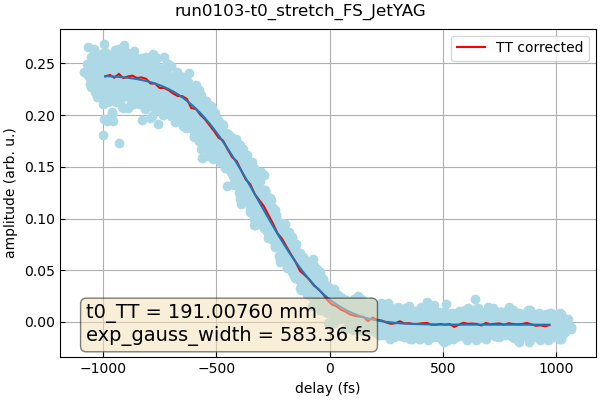

Position t0_raw = 191.05492 mm
Position t0_TT = 191.00760 mm


In [39]:
#fig, ax = plt.subplots(figsize=(5,3),constrained_layout=True, dpi = 120)
fig, ax = plt.subplots(figsize=(6,4),constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3] )#+ " mono")

plt.tick_params(direction='in')

plt.plot(Delays_corr, Pump_probe_scan, 'o', color='lightblue')#, markersize=0.5)
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_fit)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {:.5f} mm'.format(Timezero_mm + fs2mm(t0_fs,0)),
            r'exp_gauss_width = {:.2f} fs'.format(np.abs(width_fs))))
plt.text(0.05, 0.05, boxtext, transform = ax.transAxes, bbox = boxstyle, fontsize = 14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.xlim(-300, 300)
#plt.ylim(-0.025, 0.05)

plt.grid()
plt.show()

print("Position t0_raw = {:.5f} mm".format(Timezero_mm ))
print("Position t0_TT = {:.5f} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

# fit with pseudo-voigt

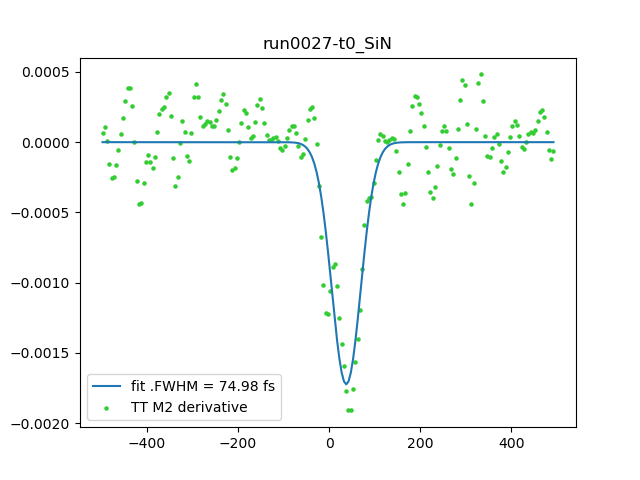

In [27]:
from lmfit.models import PseudoVoigtModel

pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)

mod = PseudoVoigtModel()
pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=0.05, center= 0, sigma=0.4, fraction=0.5, x=Delay_fs_TT)

plt.figure()
plt.title(jsonfile.split('/')[-3])
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
#plt.plot(Delay_fs_TT, out.init_fit, '--', label='initial fit')
plt.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit .FWHM = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
plt.legend()
plt.show()

# fit with Gaussian

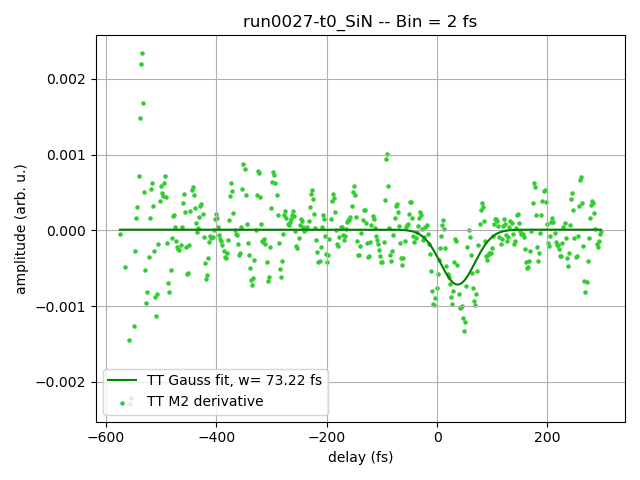

[ 3.72497749e+01 -7.24679087e-04  3.10933491e+01  8.83667703e-06]


In [10]:
pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [-20, 0, 20, 0])

plt.figure()
plt.title(jsonfile.split('/')[-3]+ ' -- Bin = {} fs'.format(binsize))
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'TT Gauss fit, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

plt.legend(loc='lower left')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()

print(parameters_M2)

In [11]:
Delay_fs_TT.shape

(499,)

In [12]:
def load_reduced_data(pgroup, loaddir, runlist):
    from collections import defaultdict
    titlestring = pgroup + ' --- ' +str(runlist)

    d = defaultdict(list)
    for run in runlist:
        data = {}
        file = glob.glob(loaddir + '/*{:04d}*/*run_array*'.format(run))
        run_array = np.load(file[0], allow_pickle=True).item()
        for k, v in run_array.items():
            for key, value in v.items():
                data[key] = value
                d[key].extend(value)
                # if "scan" in key:
                #     d[key].extend(value)
                # else:
                #     d[key].extend(value)
    return d, titlestring

In [17]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_YAG_TT'

runlist1=np.arange(124, 126)
runlist2=np.arange(127, 129)
runlist= list(runlist1)+list(runlist2)

##############################################
from textwrap import wrap
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scans, {} total shots'.format(len(runlist), len(Delay_corr)))


TypeError: expected str, bytes or os.PathLike object, not list

In [ ]:
plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(Delay_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delay_fs, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
binsize = 2 # in fs

min_delay = -400
max_delay = 400

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delay_corr))

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delay_corr, Pump_probe_scan, statistic=np.nanmean, bins=binList)

In [ ]:
index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
print(fit.p0)
fit.p0 = better_p0(fit.p0, 4,200)# overwrite some values (index) if needed: 
#fit.p0 =[0, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[0, 0.04, 50, 0.0, 500]
print(fit.p0)

fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = Timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(titlestring_stack)

plt.tick_params(direction='in')

plt.plot(Delay_corr, Pump_probe_scan, 'o', color='lightblue')#, markersize=0.5)
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_fit)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero_mm + fs2mm(t0_fs,0),5)),
            r'exp_gauss_width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
plt.ylim(-0.03, 0.17)
#plt.xlim(-600, 600)
plt.grid()
plt.show()

print("Position t0_raw = {} mm".format(Timezero_mm ))
print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

In [ ]:
pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-55, 0])

plt.figure()
plt.title(titlestring_stack+ ' -- Bin = {} fs'.format(binsize))
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'TT Gauss fit, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

plt.legend(loc='lower left')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()

print(parameters_M2)

# std analysis on rebinned data

In [18]:
binsize = 2 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delay_fs[0] - 100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
pp_std, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='std', bins=binList)

(10087,) (10087,)


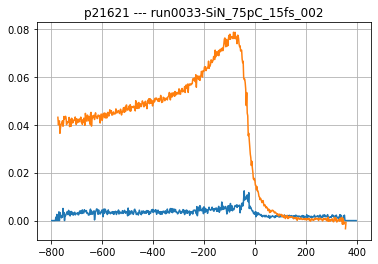

In [19]:
plt.figure()
plt.title(titlestring)
plt.plot(Delay_fs_TT,pp_std)
plt.plot(Delay_fs_TT,pp_TT)
plt.grid()
plt.show()

# Load & plot data (rebinned)

In [20]:
#unlist = np.arange(13, 25, 1)
runlist = [23, 29, 30]

Loaddir = '../Claudio/Reduced_YAG_TT/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*npy*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 3 runs: [23, 29, 30] from ../Claudio/Reduced_YAG_TT/
Some runs are missing
Some runs are missing
Some runs are missing


[]

In [21]:
binsize = 5 # in fs

from scipy.stats import binned_statistic
plt.figure(figsize=(10,8))

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Delay_rbk = run_array[key]["Delay_rbk"]
        Delay_fs = run_array[key]["Delay_fs"]
        Pump_probe_scan = run_array[key]["Pump_probe_scan"]
        Delays_corr = run_array[key]["Delay_corr"]
        
        binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
        Delay_fs_TT = np.arange(Delay_fs[0] - 100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

        pp_std, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='std', bins=binList)
        pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
                
#        plt.plot(delays_rbk, (sigma_pump/sigma_unpump), label = runnumber)
#        plt.plot(Delay_fs_TT+Delay_rbk[0], pp_std/np.nanmax(pp_TT), label = runnumber)
#        plt.plot(Delay_fs_TT+Delay_rbk[0], pp_std, label = runnumber)
#        plt.plot(Delay_fs_TT, pp_TT, label = runnumber)
        if (runnumber=='run0023'):
            Delay_fs_TT+=20
        plt.plot(Delay_fs_TT, pp_TT, label = runnumber)

plt.grid()
plt.ylabel('std')
plt.xlabel("delay (fs)")
plt.legend(loc = 'best')
plt.show()


IndexError: list index out of range

<Figure size 720x576 with 0 Axes>

(array([  2.,   2.,   7.,  12.,  24.,  31.,  60.,  68.,  94., 106.,  99.,
         79.,  64.,  67.,  37.,  53.,  76., 104., 104., 107., 125., 117.,
        157., 132., 120., 123.,  91.,  94.,  96., 105., 121., 128., 101.,
        126., 124., 131., 152., 121., 156., 122., 143., 113., 127., 138.,
        116., 106.,  83.,  86.,  76.,  75.,  87.,  96., 121., 146., 157.,
        148.,  99., 123., 102.,  96., 106.,  99., 126., 116., 128., 100.,
        120., 131., 114., 112., 105.,  98.,  98., 118., 116., 127., 125.,
        125., 138., 112., 119., 134., 145., 144., 114., 108., 102., 129.,
        112., 130., 122., 105., 118.,  71.,  74.,  82.,  47.,  27.,  11.,
          3.]),
 array([-810.86517986, -799.0805683 , -787.29595674, -775.51134518,
        -763.72673362, -751.94212207, -740.15751051, -728.37289895,
        -716.58828739, -704.80367583, -693.01906428, -681.23445272,
        -669.44984116, -657.6652296 , -645.88061804, -634.09600649,
        -622.31139493, -610.52678337, -598.742

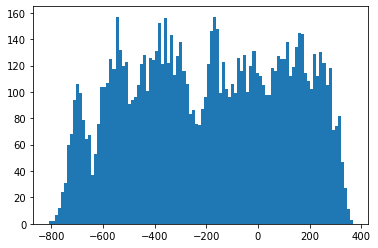

In [25]:
plt.hist(Delays_corr, bins = 100)

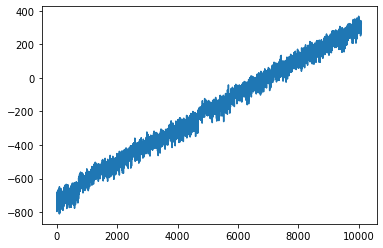

In [26]:
plt.plot(Delays_corr)